# Predicting Knowledge Level of Students in Electrical DC Machines

# Introduction

Electrical DC Machines are essential components of many electrical systems, and students learning about this subject must have a good understanding of it. In this project, we aim to analyze the student's knowledge status about the subject of Electrical DC Machines. The dataset used in this project is obtained from a Ph.D. thesis. and the dataset was obtained from the UCI Machine Learning Repository titled "User knowledge Modelling Data Set".

We want to answer the following question:

**Can we predict the knowledge level of students in Electrical DC Machines based on their study habits?**

This dataset contains information on students knowledge status about Electrical DC Machines, including their study time for goal object materials (STG), degree of repetition number of user for goal object materials (SCG), degree of study time of user for related objects with goal object (STR), exam performance of user for related objects with goal object (LPR), exam performance of user for goal objects (PEG), and knowledge level of the user (UNS). The UNS column is the target variable, with four possible values: Very Low, Low, Middle, and High.

# Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(readxl)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
temp_file <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", temp_file)
data_training <- read_excel(temp_file, sheet = 2)
head(data)

New names:
• `` -> `...7`
• `` -> `...8`


                                                                            
1 function (..., list = character(), package = NULL, lib.loc = NULL,        
2     verbose = getOption("verbose"), envir = .GlobalEnv, overwrite = TRUE) 
3 {                                                                         
4     fileExt <- function(x) {                                              
5         db <- grepl("\\\\.[^.]+\\\\.(gz|bz2|xz)$", x)                     
6         ans <- sub(".*\\\\.", "", x)                                      

In [3]:
temp_file <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", temp_file)
data <- read_excel(temp_file, sheet = 2)

#Data is already in tidy format
data_required <- data |> select(STG,SCG,STR,LPR,PEG,UNS) |> drop_na()
head(data_required)

#Summarizing
nrow(data_required)
data_split <- initial_split(data_required,prop = 0.80, strata = UNS)
data_training <- training(data_split)
data_test <- testing(data_split)

head(data_training)
head(data_test)

New names:
• `` -> `...7`
• `` -> `...8`


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


[1] 258

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.18,0.18,0.55,0.30,0.81,High
0.10,0.10,0.70,0.15,0.90,High
0.12,0.12,0.75,0.35,0.80,High
0.05,0.07,0.70,0.01,0.05,very_low


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.000,0.50,0.20,0.85,High
0.10,0.270,0.31,0.29,0.65,Middle
0.06,0.290,0.35,0.76,0.25,Low
0.09,0.255,0.60,0.45,0.25,Low
0.15,0.275,0.80,0.21,0.81,High
0.15,0.295,0.75,0.65,0.24,Low


In [4]:
num_obs <- nrow(data_required)

data_summary <- data_required %>%
  group_by(UNS) %>%
  summarize(
    count = n(),
    percentage = (n()/num_obs) * 100
  )

data_summary

UNS,count,percentage
<chr>,<int>,<dbl>
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527
very_low,24,9.302326


In [5]:
data_summary_train <- data_training |>
  group_by(UNS) |>
  summarize(
    count = n(),
       percentage = (n()/num_obs) * 100,
       STG_mean = mean(STG, na.rm = TRUE),
       SCG_mean = mean(SCG, na.rm = TRUE),
       STR_mean = mean(SCG, na.rm = TRUE),
       LPR_mean = mean(LPR, na.rm = TRUE),
       PEG_mean = mean(PEG, na.rm = TRUE))

data_summary_train

UNS,count,percentage,STG_mean,SCG_mean,STR_mean,LPR_mean,PEG_mean
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
High,49,18.992248,0.4263878,0.4392041,0.4392041,0.5146939,0.76204082
Low,66,25.581395,0.3190909,0.3571515,0.3571515,0.4927273,0.23459091
Middle,70,27.131783,0.3914286,0.3516000,0.3516000,0.3597143,0.53557143
very_low,21,8.139535,0.2835238,0.2069048,0.2069048,0.3419048,0.09095238


UNS,study_habit,mean
<chr>,<chr>,<dbl>
High,STG_mean,0.4263878
High,SCG_mean,0.4392041
High,STR_mean,0.4392041
Low,STG_mean,0.3190909
Low,SCG_mean,0.3571515
Low,STR_mean,0.3571515
Middle,STG_mean,0.3914286
Middle,SCG_mean,0.3516000
Middle,STR_mean,0.3516000


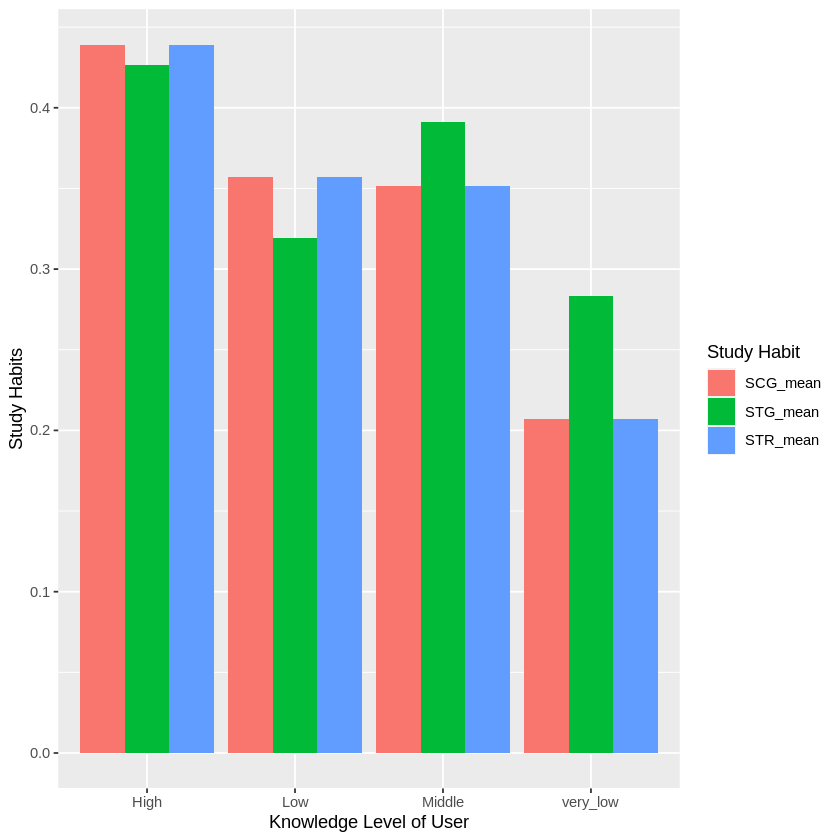

In [8]:
data_mean <- data_summary_train |>
    select(-count, -percentage, -LPR_mean, -PEG_mean) |>
    pivot_longer(cols = c(STG_mean, SCG_mean, STR_mean),
                 names_to = "study_habit",
                 values_to = "mean")
data_mean

study_habits_mean_vs_knowledge_plot <- ggplot(data_mean, aes(x = UNS, y = mean, fill = study_habit)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(x = "Knowledge Level of User", y = "Study Habits", fill = "Study Habit")
study_habits_mean_vs_knowledge_plot

# Methods

We will conduct our data analysis by investigating the following columns: STG, SCG, and STR, these are all about study habits and their meanings were discussed above. We will be trying to predict the UNS.

# Expected outcomes and significance

### What do you expect to find?

### What impact could such findings have?

### What future questions could this lead to?